In [5]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from src.features import utils, build_features_final, build_features
from src.models import predict_model
from src.train.train import train, evaluation, prediction_to_csv
from src.data.make_dataset import DatasetLoader
from src.visualization.visual import anomaly_plot
from src.config.config import seed_everything, cfg

warnings.filterwarnings(action='ignore')
seed_everything(cfg.SEED)

scaler = MinMaxScaler()

train_data = pd.read_csv(r'data\raw\train_data.csv')
# add_train = pd.read_csv(r'data\raw\test_data.csv')
# train_data = utils.outlier_z_score_filter_df(train_data, threshold=3.5)
# train_data = pd.concat([train_data, add_train], axis=0)
train_data = build_features_final.create_derived_features(train_data)

test_data = pd.read_csv(r'data\raw\test_data.csv')
test_data = build_features_final.create_derived_features(test_data)

scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

scaled_train_data = pd.DataFrame(scaled_train_data, columns=train_data.columns)
scaled_test_data = pd.DataFrame(scaled_test_data, columns=train_data.columns)

scaled_train_data_df = scaled_train_data.copy()
scaled_test_data_df = scaled_test_data.copy()

grouped_train = scaled_train_data.groupby('type')

drop_feature = ['type', 'motor_hp', 'air_end_temp', 'motor_rpm', 'motor_temp', 'motor_vibe', 'motor_current',
                'air_inflow', "air_flow_pressure", "current_by_vibration", "airflow_per_rotation", 'volumetric_efficiency',
                'air_to_motor_ratio']

anomaly = []
all_threshold = []
train_ths = []
for group_name, group_data in grouped_train:
    test_group = scaled_test_data[scaled_test_data['type'] == group_name]
    train_group = group_data.drop(drop_feature, axis=1).values
    test_group = test_group.drop(drop_feature, axis=1).values

    n_features = train_group.shape[1]
    print(n_features)
    dataloader = DatasetLoader(train_group, test_group)
    train_loader, test_loader = dataloader.load
    model = predict_model.PowerfulConv1DLSTMAutoencoder()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train(train_loader, model, criterion, optimizer)

    train_prediction, train_threshold = evaluation(train_loader, model)
    test_prediction, test_threshold = evaluation(test_loader, model, max(train_threshold))

    anomaly.append(test_prediction)
    all_threshold.append(test_threshold)
    train_ths.append(train_threshold)
    print(f"finish {group_name}type")

all_threshold = np.concatenate(all_threshold)
anomaly = np.concatenate(anomaly)
train_ths = np.concatenate(train_ths)
submission = prediction_to_csv(anomaly)

11
Epoch [0/400], Loss: 0.0933174
Epoch [100/400], Loss: 0.0020919
Epoch [200/400], Loss: 0.0007226
Epoch [300/400], Loss: 0.0005438
finish 0.0type
11
Epoch [0/400], Loss: 0.0808071
Epoch [100/400], Loss: 0.0019007
Epoch [200/400], Loss: 0.0008191
Epoch [300/400], Loss: 0.0005381
finish 0.14285714285714285type
11
Epoch [0/400], Loss: 1.0684022
Epoch [100/400], Loss: 0.0225373
Epoch [200/400], Loss: 0.0023065
Epoch [300/400], Loss: 0.0011142
finish 0.2857142857142857type
11
Epoch [0/400], Loss: 0.0853926
Epoch [100/400], Loss: 0.0032869
Epoch [200/400], Loss: 0.0006677
Epoch [300/400], Loss: 0.0005314
finish 0.42857142857142855type
11
Epoch [0/400], Loss: 0.3092137
Epoch [100/400], Loss: 0.0064673
Epoch [200/400], Loss: 0.0011210
Epoch [300/400], Loss: 0.0007088
finish 0.5714285714285714type
11
Epoch [0/400], Loss: 0.3726170
Epoch [100/400], Loss: 0.0051245
Epoch [200/400], Loss: 0.0010075
Epoch [300/400], Loss: 0.0006326
finish 0.7142857142857142type
11
Epoch [0/400], Loss: 0.6645414
E

In [6]:
test_data['label'] = anomaly
test_data['treshold'] = all_threshold
def no_out(test_data):
    test7342 = test_data[7342:7361]
    no = test7342[test7342['label']==1]
    yes = test7342[test7342['label']==0]
    return yes, no
yes, no = no_out(test_data)

Chunk 0: 144/1296 labels with value 1


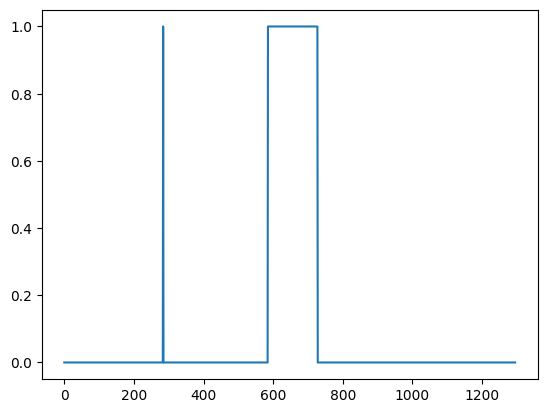

Chunk 1: 0/1107 labels with value 1


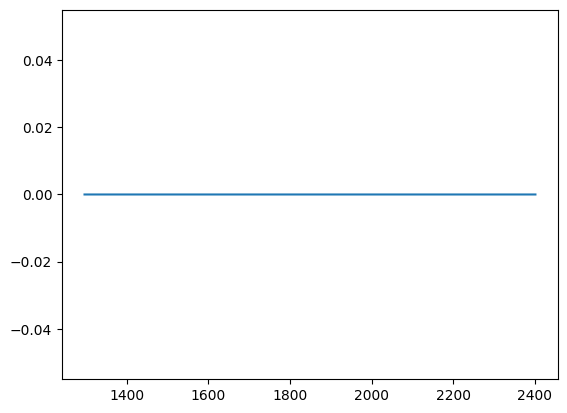

Chunk 2: 26/1098 labels with value 1


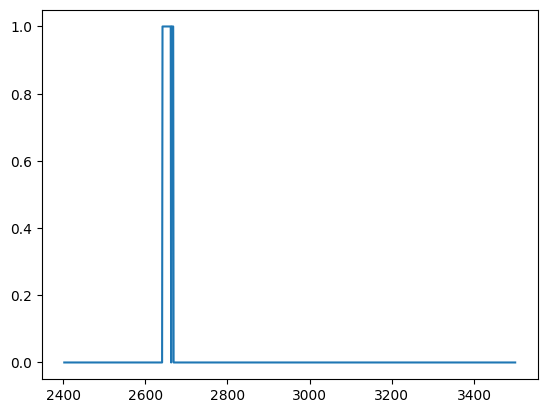

Chunk 3: 26/918 labels with value 1


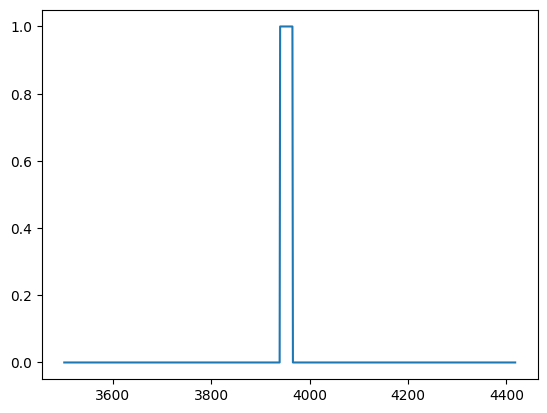

Chunk 4: 17/918 labels with value 1


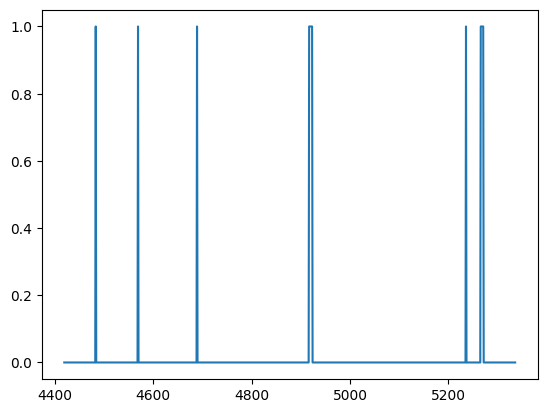

Chunk 5: 36/746 labels with value 1


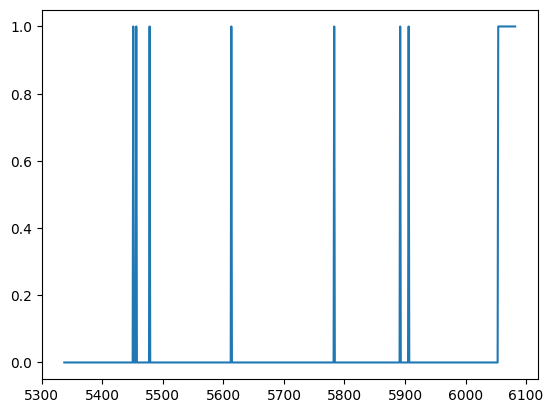

Chunk 6: 106/748 labels with value 1


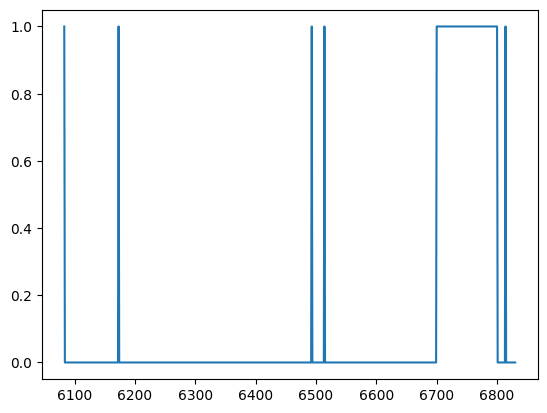

Chunk 7: 9/558 labels with value 1


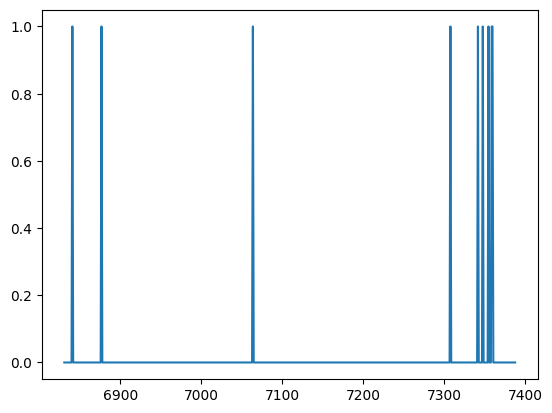

In [8]:
def plot_label_counts(predictions, chunk_sizes):
    for i, (start, end) in enumerate(chunk_sizes):
        chunk = predictions[start:end]
        num_labels = len(chunk[chunk['label'] == 1])
        print(f"Chunk {i}: {num_labels}/{len(chunk)} labels with value 1")
        plt.plot(chunk['label'])
        plt.show()
ranges = [(0, 1296), (1296, 2403), (2403, 3501), (3501, 4419), (4419, 5337), (5337, 6083), (6083, 6831), (6831, len(anomaly))]
plot_label_counts(submission, ranges)